## GPT 2 architecture

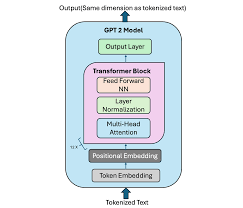

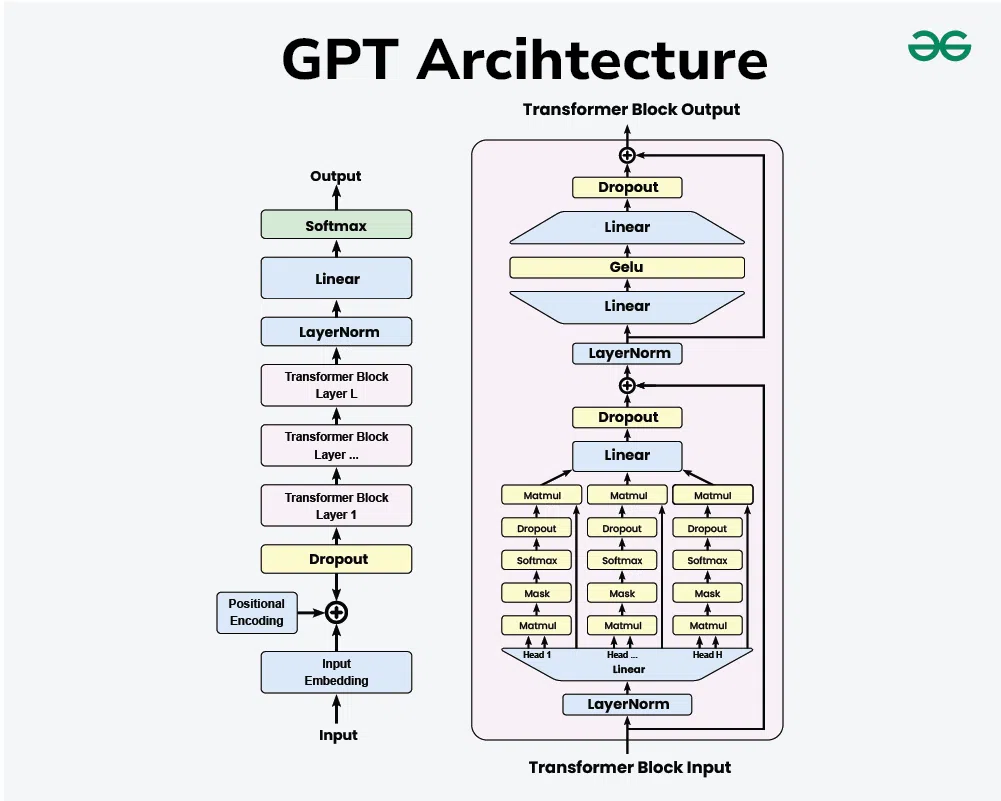

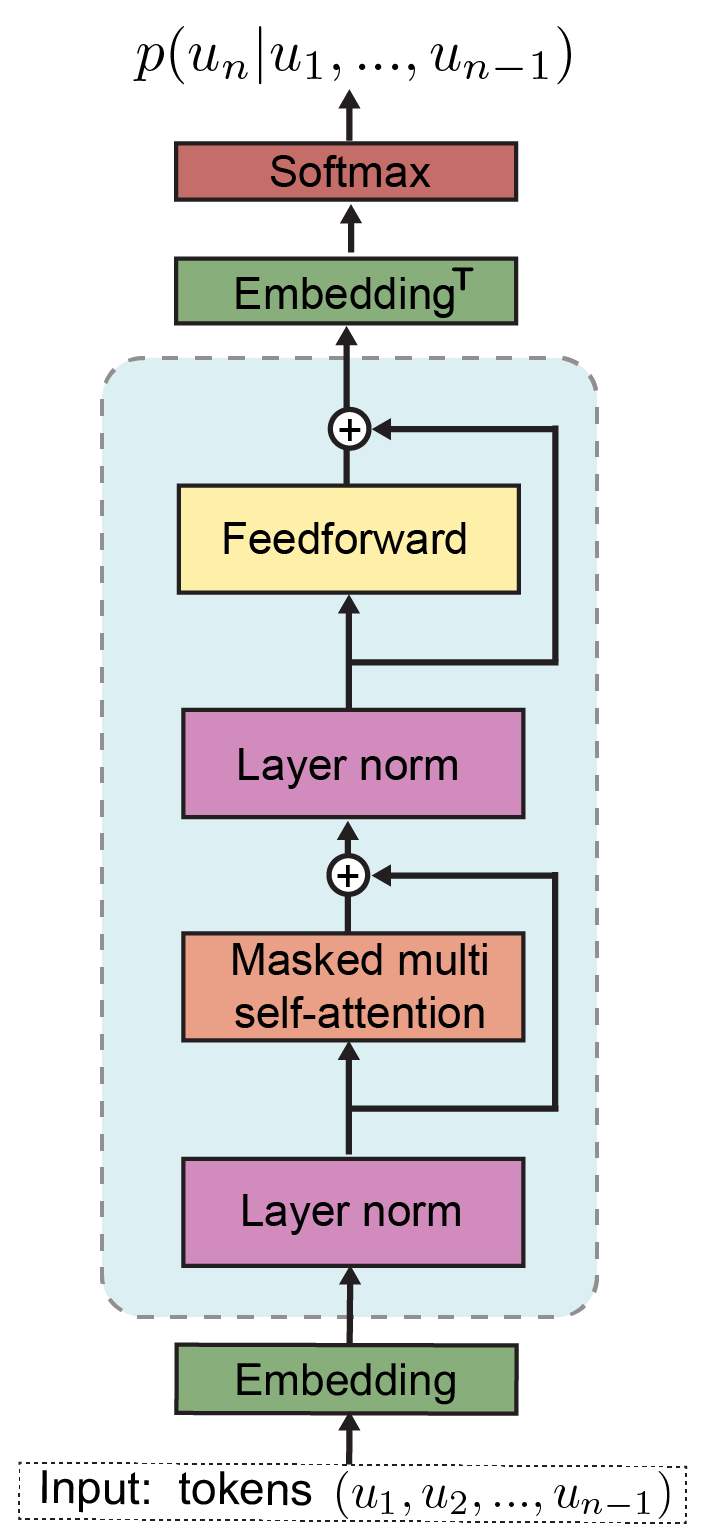

## Layer Normalisation
1. Traing deep NN with many layers can be challenging due to vanishing/ exploding gradient problem and leads to unstabe training dynamics
2. Layer Normalization improves the stability and efficiency of neural network.
3. It also prevents internal covariate shift which delays convergence.
4. After the Normalization the mean is 0 and variance is 1.
5. Core output: adjust the weight of neural network to have mean is 0 and variance is 1 and it speed up the convergence.
6. In models like GPT-2 , Layer normalization appears before masked mutli head attention and feed forward network in transformer block



In [1]:
## example
import torch
import torch.nn as nn
torch.manual_seed(123)
batch_example = torch.randn(2,5) ## two batch with 5 inputs
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
out


tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

In [2]:
mean= out.mean(dim = -1,keepdim=True)
var = out.var(dim = -1, keepdim=True)
print(mean)
print(var)

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [3]:
## applying noramlizaton
out_norm = (out-mean)/torch.sqrt(var)
mean = out_norm.mean(dim= -1, keepdim = True)
var = out_norm.var(dim= -1, keepdim = True)
print("Normalized layer output", out_norm)
print("Mean after normalization", mean)
print("Variance after normalization", var)


Normalized layer output tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean after normalization tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance after normalization tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [4]:
## coding Layer normalization class

class LayerNorm(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(embed_dim)) ## parameter of the same dim of input that LLM automatically adjust during training, this allows model to learn appropriate scaling and shifting that best suits the data it process
    self.shift = nn.Parameter(torch.zeros(embed_dim))

  def forward(self,x):
    mean = x.mean(dim = -1, keepdim = True)
    var = x.var(dim= -1, keepdim= True, unbiased = False) ## unbiased false turns off the bessels correction
    norm_x = (x-mean)/ torch.sqrt(var+self.eps) # added eps to ignore division by 0
    return self.scale*norm_x + self.shift

In [5]:
ln = LayerNorm(embed_dim = 5)
out_ln = ln(batch_example)
out_ln

tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)

In [6]:
mean = out_ln.mean(dim = -1, keepdim = True)
var = out_ln.var(dim = -1, keepdim = True)
print(mean)
print(var)

tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
tensor([[1.2499],
        [1.2500]], grad_fn=<VarBackward0>)


## GELU activation function
1. GELU activation function is implemented in Feed forward network in transformer
2. Why dont we use ReLU becuase it creates a problem of dead neuron, becuase if the weight value is less than 0 it is always 0 make the neuron dead and not learning
3. thats why we use GELU: it is CDF of standard Gaussian distribution
where 𝛷(𝑥) is the standard Gaussian CDF.

      𝐺𝐸𝐿𝑈(𝑥)=𝑥⋅𝛷(𝑥)




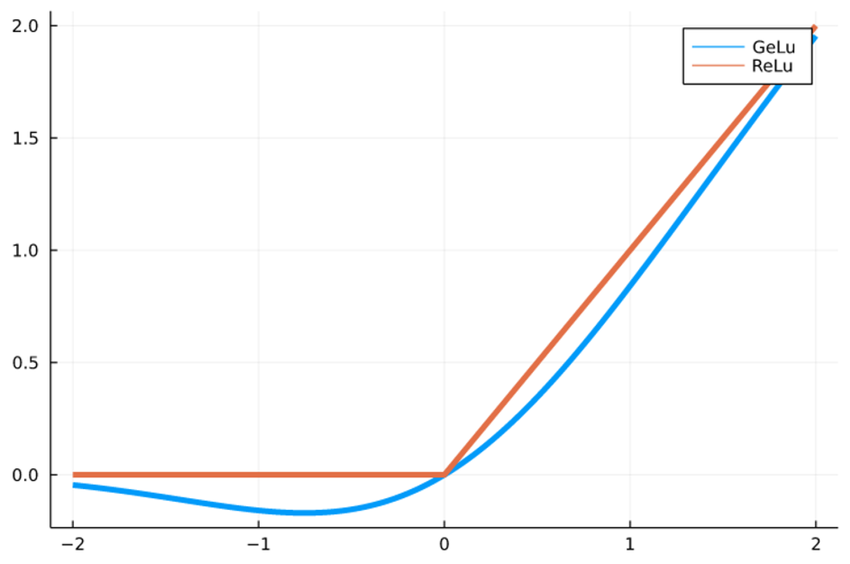

In [7]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi)) * (x + 0.044715 * torch.pow(x,3)) ## we use approximation instead of CDF and it is used in GPT 2 model
    ))


In [8]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers":12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [9]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"] )
    )
  def forward(self,x):
    return self.layers(x)


In [10]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768)
out = ffn(x)
out.shape


torch.Size([2, 3, 768])

## Skip or shortcut Connection

The shortcut (residual) connection in a Transformer block is a simple element-wise addition of the sub-layer's input to its output. This design is crucial for enabling the training of deep networks by ensuring stable gradient flow and helping layers learn residual functions.
1. Mitigation of Vanishing Gradients
2. Optimization Stability
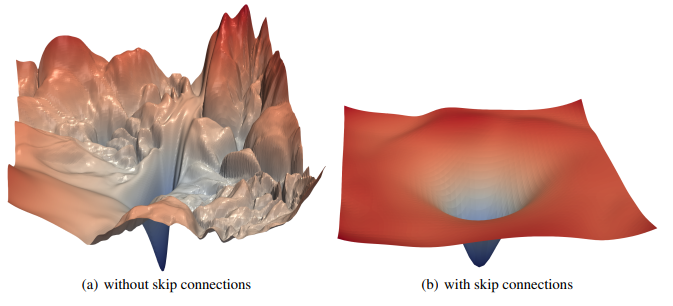

## Coding Transformer Block

In [11]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers":12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [12]:
class MutliHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
    super().__init__()
    assert (d_out % num_heads) == 0, \
      "d_out must be divisible by the num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads ## reducing the projection dim to match the desired outpit dim
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out) ## lear layer to combine the head output
    self.dropout = nn.Dropout(dropout)
    self.register_buffer( ## register_buffer method is used to manage and save tensors that are part of a module's state but are not trainable parameters.When you move your model to a different device (e.g., from CPU to GPU) using model.to(device), any tensors registered as buffers will automatically be moved to that same device
        "mask",
        torch.triu(torch.ones(context_length, context_length), diagonal=1)
    )
  def forward(self, x): ## lets x = "the cat sleeps" and num of head is 2
    b,num_tokens, d_in = x.shape
    query = self.W_query(x)
    key = self.W_key(x)
    value = self.W_value(x)

    ## we implicitly split the matrix by adding a 'num_heads' dimension
    keys = key.view(b, num_tokens, self.num_heads, self.head_dim)
    values = value.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = query.view(b, num_tokens, self.num_heads, self.head_dim)

    ## currently the shape is [1,3,2,3] if the batch size is 1, num of tokens is 3, heads is 2 and head dim is 3
    ## so lets transpose it for index 1,2 to make it [1,2,3,3]
    keys = keys.transpose(1,2)
    values = values.transpose(1,2)
    queries = queries.transpose(1,2)

    ## computing the scaled attention score with causal mask
    attn_score = queries @ keys.transpose(2,3)

    ## original mask truncated to number of tokens and converted to boolean
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
    attn_score.masked_fill_(mask_bool, -torch.inf)
    attn_weights = torch.softmax(attn_score/self.head_dim**0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)

    ## shape: (b, num_tokens, num_heads, head_dim)
    context_vecs = (attn_weights @ values).transpose(1,2)
    context_vecs = context_vecs.contiguous().view(b,num_tokens, self.d_out)
    context_vecs= self.out_proj(context_vecs)
    return context_vecs

In [13]:
class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.att = MutliHeadAttention(
        d_in = cfg["emb_dim"],
        d_out= cfg["emb_dim"],
        context_length= cfg["context_length"],
        dropout= cfg["drop_rate"],
        num_heads= cfg["n_heads"],
        qkv_bias = cfg["qkv_bias"]
    )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    ## adding shortcut for attention block
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = shortcut + x

    ### adding shortcut connection for feedforward block
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x


In [14]:
torch.manual_seed(123)
x = torch.rand(2,4,768)
block = TransformerBlock(GPT_CONFIG_124M)
y = block(x)
y.shape

torch.Size([2, 4, 768])

## Coding the 124 million parameter GPT-2 model


In [15]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers":12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [21]:
class GPT(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"]) ## number of embedding, and token dimension(768)
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"]) ## it will take only the context length and dimenstion
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

  def forward(self,in_idx):
    batch_size, seq_len = in_idx.shape
    ## inputing tokens
    token_embed = self.tok_emb(in_idx)
    ## positional encoding
    pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
    ## adding encodings
    x = token_embed + pos_embeds
    ## adding dropour layer
    x = self.drop_emb(x)
    ## now going through all transformer blocks => 12
    x = self.trf_blocks(x)
    ## final normalization layer
    x = self.final_norm(x)
    ## output
    logits = self.out_head(x) ## shape : [batch, num_tokens, vocab_size ]
    return logits

In [23]:
torch.manual_seed(123)
model = GPT(GPT_CONFIG_124M)
# Create a dummy input tensor with integer type
dummy_input = torch.randint(0, GPT_CONFIG_124M["vocab_size"], (2, 10))
out = model(dummy_input)
out.shape

torch.Size([2, 10, 50257])

In [24]:
## calculatiing the parameter of the model
total_params = sum(p.numel() for p in model.parameters())
total_params

163009536